In [446]:
from qiskit import *
import numpy as np

from qiskit.visualization import plot_histogram
from qiskit import IBMQ, Aer
from scipy.optimize import minimize
from qiskit.providers.fake_provider import FakeToronto
import time

provider=IBMQ.load_account()
times = {
    "rx": {
        3: [],
        4: [],
        5: [],
        6: [],
    },
    "had": {
        3: [],
        4: [],
        5: [],
        6: [],
    }
}

ibmqfactory.load_account:WARNING:2022-12-04 23:59:47,035: Credentials are already in use. The existing account in the session will be replaced.


In [447]:
def QAOA_Vertex_Cover(connections,gamma,beta):
    n=max(map(max, connections))+1
    qc=QuantumCircuit(n+1,n)


    qc.x(n)
    qc.h(range(n))
    
    
    qc.barrier()
    for i in connections:
        qc.cp(-1*gamma,i,n)
        qc.mcp(gamma,i,n)

        
    qc.barrier()


    for i in range(n):
        qc.x(i)
        qc.cp(-1*gamma,i,n)
        qc.x(i)


    qc.barrier()


    qc.rx(2*beta, range(n))


    qc.measure(range(n),range(n))

    return qc

def QAOA_Vertex_Cover_had(connections,gamma,beta):
    n=max(map(max, connections))+1
    qc=QuantumCircuit(n+1,n)


    qc.x(n)
    qc.h(range(n))
    
    
    qc.barrier()
    for i in connections:
        qc.cp(-1*gamma,i,n)
        qc.mcp(gamma,i,n)

        
    qc.barrier()


    for i in range(n):
        qc.x(i)
        qc.cp(-1*gamma,i,n)
        qc.x(i)


    qc.barrier()


    qc.rx(2/np.sqrt(2)*beta, range(n))
    qc.rz(2/np.sqrt(2)*beta, range(n))


    qc.measure(range(n),range(n))

    return qc




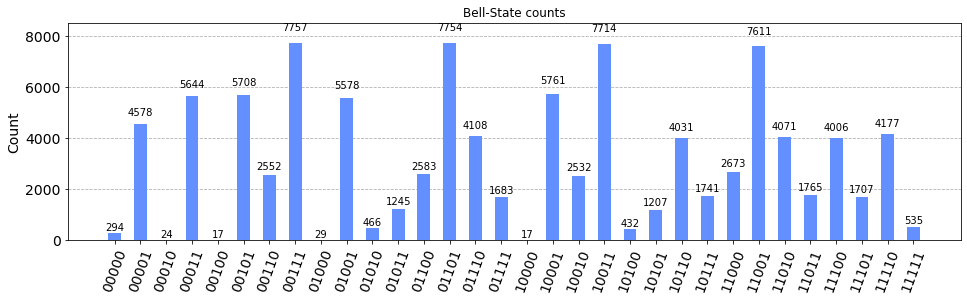

In [448]:
connections=[[0,1],[0,2],[0,3],[0,4],[1,3],[2,4]]
#gamma=[0,2pi], beta=[0,pi], gamma1<gamma2

gamma=np.pi*7/4
beta=np.pi*3.5/4
qc=QAOA_Vertex_Cover(connections,gamma,beta)

qc.draw()

backend = Aer.get_backend('aer_simulator')
circ = transpile(qc, backend)

# Run and get counts
#result = simulator.run(circ,shots=100000).result()
#counts = result.get_counts(circ)
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, title='Bell-State counts',figsize=(16,4))

In [449]:
class graph:
    def __init__(self, _graph=None):
        if _graph is None:
            _graph = {}
        self._graph = _graph
      
    def getVertices(self):
        return list(self._graph.keys())
    
    def printVertices(self):
        print(self.getVertices())
    
    def getEdges(self):
        edgename = []
        for vrtx in self._graph:
            for nxtvrtx in self._graph[vrtx]:
                if {nxtvrtx, vrtx} not in edgename:
                    edgename.append({vrtx, nxtvrtx})
        ret_list = []
        for i in range(len(edgename)):
            ret_list.append([])
            for j in edgename[i]:
                ret_list[i].append(j)
        return ret_list
    
    def printEdges(self):
        print(self.getEdges())
        
    def getGraph(self):
        return self._graph
    
    def make_graph_from_connections(self, connections):
        vertexs = []
        graph_dict = {}
        for edge_list in connections:
            for vertex in edge_list:
                if vertex not in vertexs:
                    vertexs.append(vertex)
                    
        for vertex in vertexs:
            graph_dict[vertex] = []
            
        for edge_list in connections:
            if edge_list[1] not in graph_dict[edge_list[0]]:
                graph_dict[edge_list[0]].append(edge_list[1])
                
            if edge_list[0] not in graph_dict[edge_list[1]]:
                graph_dict[edge_list[1]].append(edge_list[0])
                
        self._graph = graph_dict
        
    def printGraph(self):
        print(self._graph)
          
    

In [450]:
g = graph()
g.make_graph_from_connections(connections)
g.printEdges()
g.printVertices()
g.printGraph()

[[0, 1], [0, 2], [0, 3], [0, 4], [1, 3], [2, 4]]
[0, 1, 2, 3, 4]
{0: [1, 2, 3, 4], 1: [0, 3], 2: [0, 4], 3: [0, 1], 4: [0, 2]}


In [451]:
def mvc_obj(bitstring, graph):
    obj1 = 0
    obj2 = 0
    
    for i in range(len(bitstring)):
        if bitstring[i] == '0':
            obj1 -= 1
    
    connections = graph.getEdges()
    for vtx in connections:
        if bitstring[vtx[0]] == '1' or bitstring[vtx[1]] == '1':
            obj2 -= 1
        
    return obj1 + (obj2*1.2)

def compute_expectation(counts, graph):
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = mvc_obj(bitstring[::-1], graph)
        avg += obj*count
        sum_count += count
    
    return avg/sum_count


def get_expectation(graph, backend, shots=100000):
    #simulator = Aer.get_backend('aer_simulator')
    backend.shots = shots
    connections = graph.getEdges()
            
    def execute_circ(theta):
        
        qc = QAOA_Vertex_Cover(connections,theta[0],theta[1])
        circ = transpile(qc, backend)
        res = backend.run(circ,shots).result()
        #rx_times.append(res.time_taken())
        counts = res.get_counts()
        
        return compute_expectation(counts, graph)
    
    return execute_circ

def get_expectation_had(graph, backend, shots=100000):
    #simulator = Aer.get_backend('aer_simulator')
    backend.shots = shots
    connections = graph.getEdges()
            
    def execute_circ_had(theta):
        
        qc = QAOA_Vertex_Cover_had(connections,theta[0],theta[1])
        circ = transpile(qc, backend)
        res = backend.run(circ,shots).result()
        #ry_times.append(res.time_taken())
        counts = res.get_counts()
        
        return compute_expectation(counts, graph)
    
    return execute_circ_had
    

# Testing on aer_simulator backend

In [497]:
backend = Aer.get_backend('aer_simulator')

# Rx Mixer

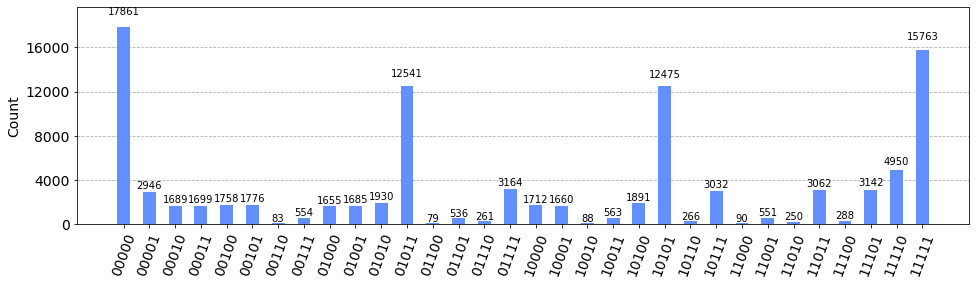

In [453]:
gamma=5
beta=2
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(connections,gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 5 ,Gamma Post-Otimization: 6.955926695802008 ,Beta Pre-Otimization: 2 ,Beta Post-Optimization: 3.603330319790864


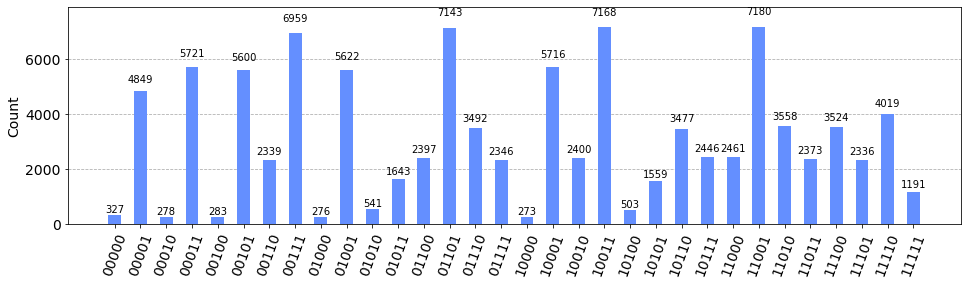

In [454]:
gamma=5
beta=2
theta = [gamma, beta]
expectation = get_expectation(g, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(connections,res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
#times["rx"][5].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

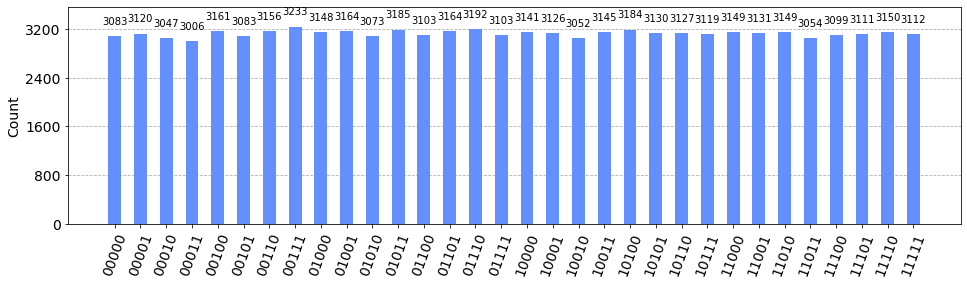

In [455]:
gamma=0
beta=0
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(connections,gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 0 ,Gamma Post-Otimization: -1.9697185547559923 ,Beta Pre-Otimization: 0 ,Beta Post-Optimization: 1.3122412013949534


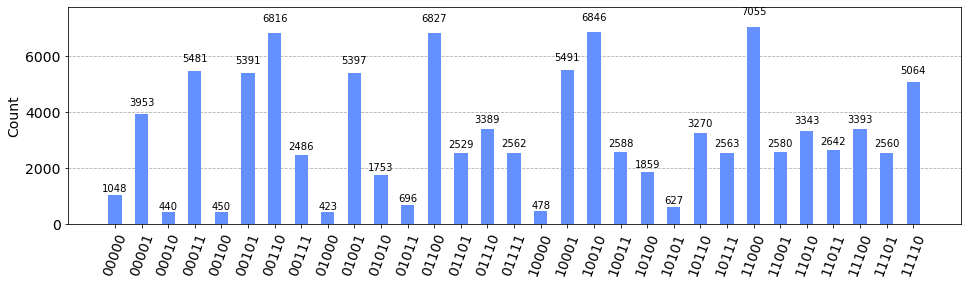

In [456]:
gamma=0
beta=0
theta = [gamma, beta]
expectation = get_expectation(g, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(connections,res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["rx"][5].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

In [457]:
graph2_dict = {
    0: [2,4],
    1: [2],
    2: [0,1,3],
    3: [2],
    4: [0]
}
g2 = graph(graph2_dict)
print(g2.getEdges())

[[0, 2], [0, 4], [1, 2], [2, 3]]


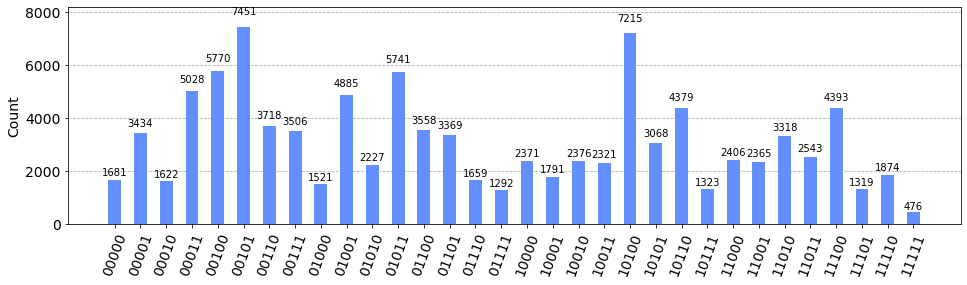

In [458]:
gamma=5
beta=3
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(g2.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 5 ,Gamma Post-Otimization: 4.72619876304237 ,Beta Pre-Otimization: 3 ,Beta Post-Optimization: 2.563967411149593


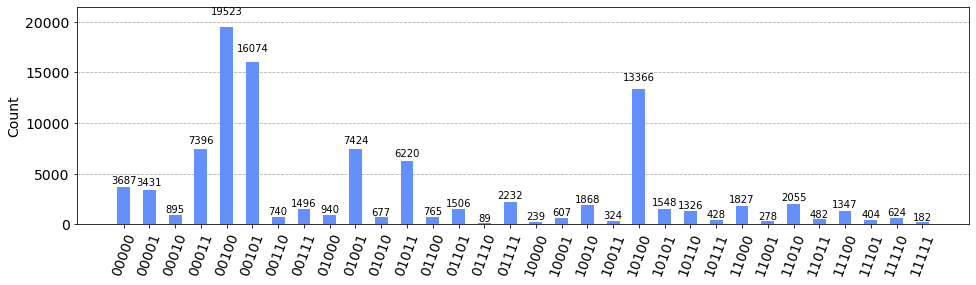

In [459]:
gamma=5
beta=3
theta = [gamma, beta]
expectation = get_expectation(g2, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g2.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
#times["rx"][5].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

In [460]:
graph3_dict = {
    0: [1,2],
    1: [0],
    2: [0,3],
    3: [2],
}
g3 = graph(graph3_dict)
print(g3.getEdges())

[[0, 1], [0, 2], [2, 3]]


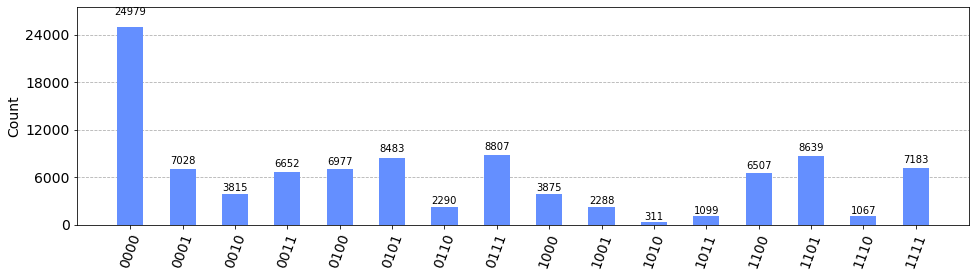

In [461]:
gamma=1
beta=1
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(g3.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 1 ,Gamma Post-Otimization: 1.0373060153868834 ,Beta Pre-Otimization: 1 ,Beta Post-Optimization: 1.9140238958730942


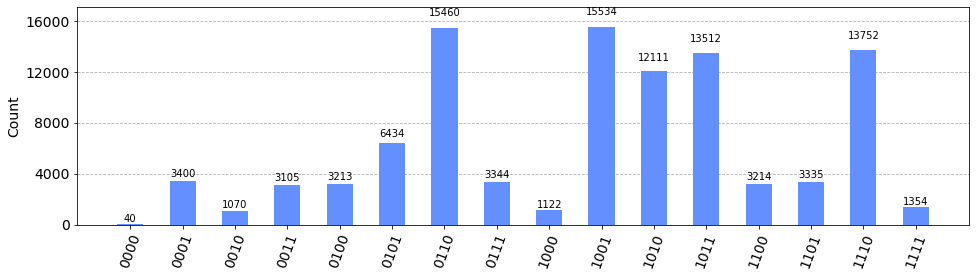

In [462]:
gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation(g3, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g3.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["rx"][4].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

In [463]:
graph4_dict = {
    0: [3],
    1: [4],
    2: [5],
    3: [0,4],
    4: [1,3,5],
    5: [2,4]
}
g4 = graph(graph4_dict)
print(g4.getEdges())

[[0, 3], [1, 4], [2, 5], [3, 4], [4, 5]]


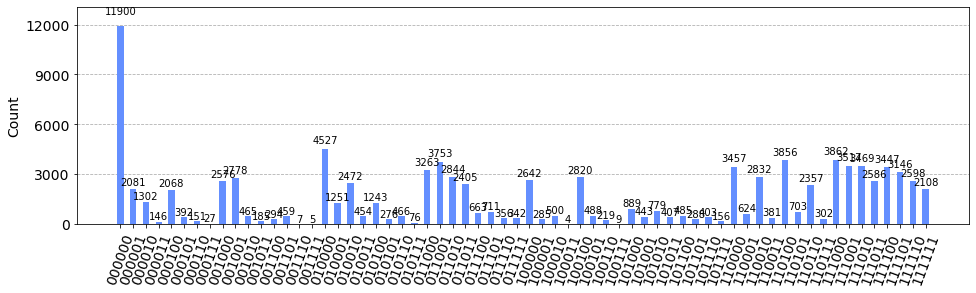

In [464]:
gamma=1
beta=1
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(g4.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 1 ,Gamma Post-Otimization: 2.061561049270918 ,Beta Pre-Otimization: 1 ,Beta Post-Optimization: 2.00499986824307


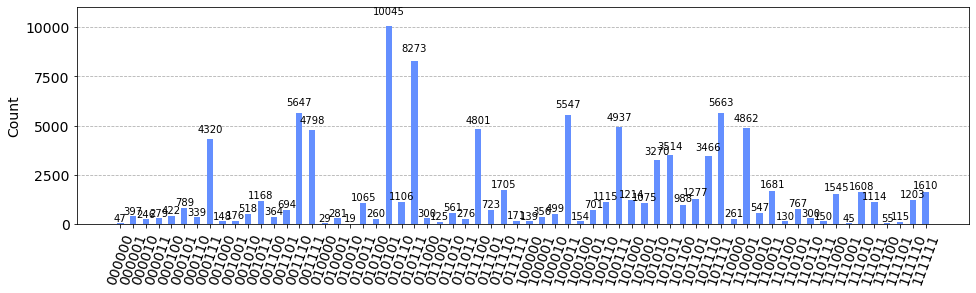

In [465]:
gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation(g4, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g4.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["rx"][6].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(16,4))

In [466]:
graph5_dict = {
    0: [1],
    1: [0,2],
    2: [1],
}
g5 = graph(graph5_dict)
print(g5.getEdges())

[[0, 1], [1, 2]]


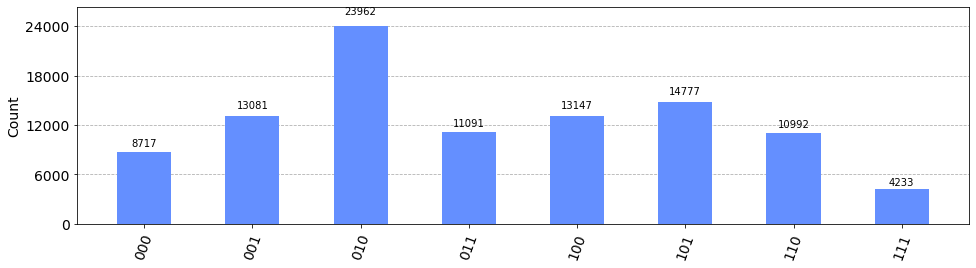

In [467]:
gamma=5
beta=3
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(g5.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 5 ,Gamma Post-Otimization: 4.5552402524950155 ,Beta Pre-Otimization: 3 ,Beta Post-Optimization: 2.68673530182584


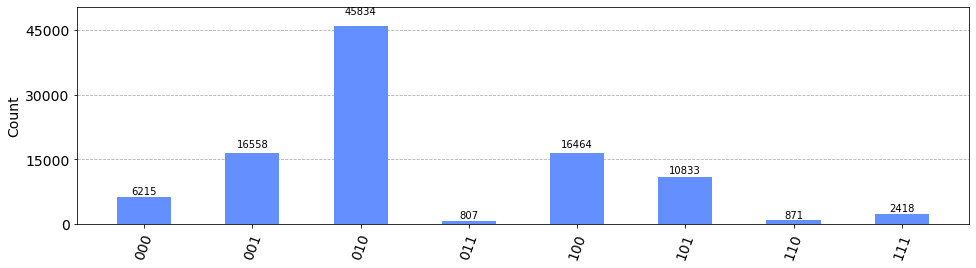

In [468]:
gamma=5
beta=3
theta = [gamma, beta]
expectation = get_expectation(g5, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g5.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["rx"][3].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(16,4))

# Hadamard Mixer

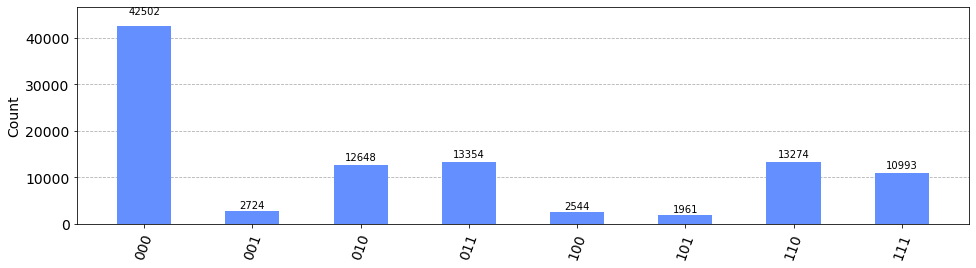

In [469]:
# 3 qubit
gamma=5
beta=3
theta = [gamma, beta]

qc=QAOA_Vertex_Cover_had(g5.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 5 ,Gamma Post-Otimization: 5.018722738714687 ,Beta Pre-Otimization: 3 ,Beta Post-Optimization: 3.7422459339442096


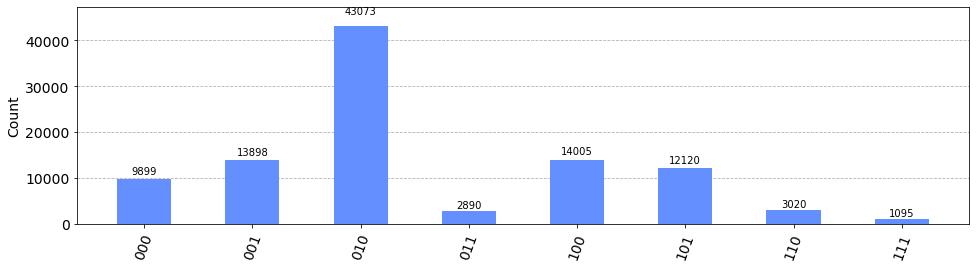

In [470]:
# 3 qubit
gamma=5
beta=3
theta = [gamma, beta]
expectation = get_expectation_had(g5, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_had(g5.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["had"][3].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(16,4))

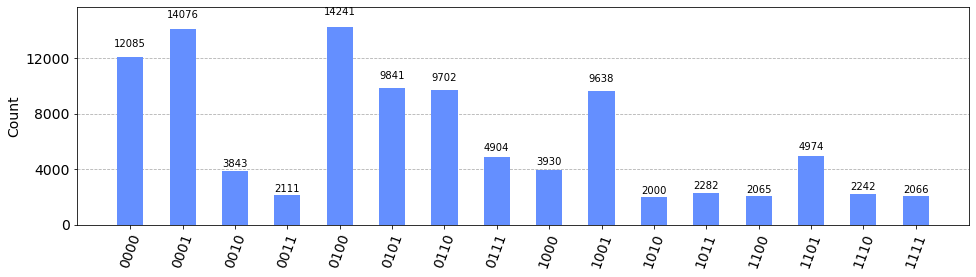

In [471]:
# 4 qubit
gamma=1
beta=1
theta = [gamma, beta]

qc=QAOA_Vertex_Cover_had(g3.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

{0: [1, 2], 1: [0], 2: [0, 3], 3: [2]}
Gamma Pre-Otimization: 1 ,Gamma Post-Otimization: 2.026301975583836 ,Beta Pre-Otimization: 1 ,Beta Post-Optimization: 0.5007813873711592


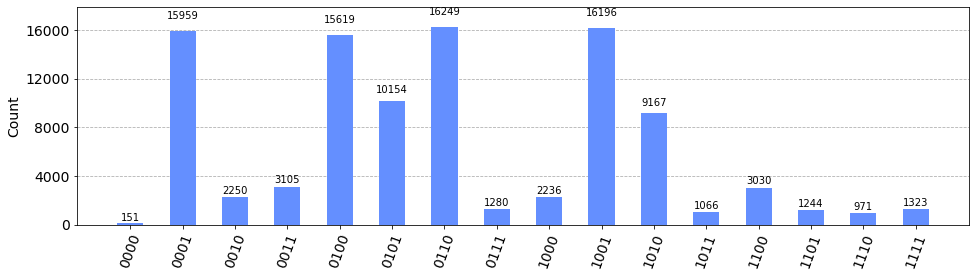

In [507]:
# 4 qubit
gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation_had(g3, backend)
g3.printGraph()

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_had(g3.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["had"][4].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

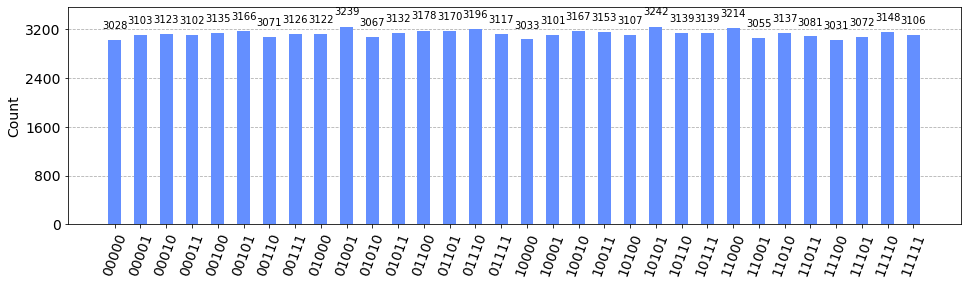

In [473]:
# 5 qubit
gamma=0
beta=0
theta = [gamma, beta]

qc=QAOA_Vertex_Cover_had(connections,gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 0 ,Gamma Post-Otimization: 0.8756177562864179 ,Beta Pre-Otimization: 0 ,Beta Post-Optimization: 0.5448473511696191


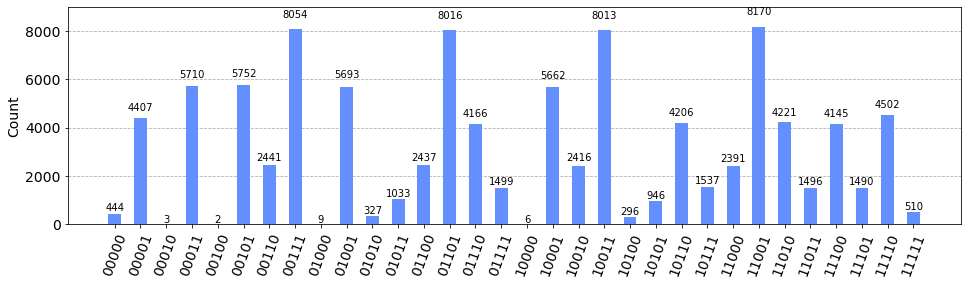

In [474]:
# 5 qubits
gamma=0
beta=0
theta = [gamma, beta]
expectation = get_expectation_had(g, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_had(connections,res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["had"][5].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

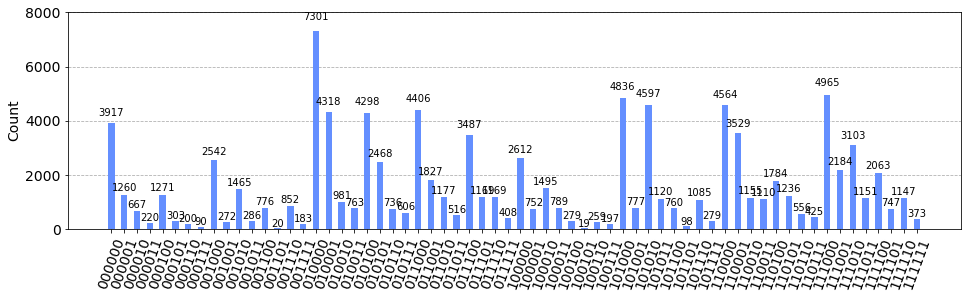

In [475]:
# 6 qubit

gamma=1
beta=1
theta = [gamma, beta]

qc=QAOA_Vertex_Cover_had(g4.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 1 ,Gamma Post-Otimization: 1.0678013463714446 ,Beta Pre-Otimization: 1 ,Beta Post-Optimization: 0.6063706681341442


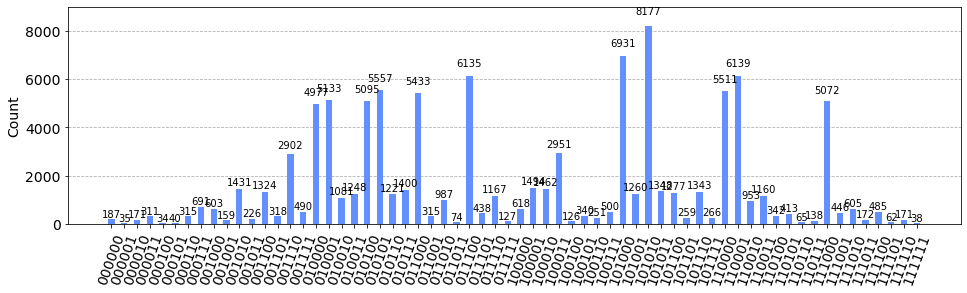

In [476]:
# 6 qubit

gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation_had(g4, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_had(g4.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["had"][6].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(16,4))

# Testing on fake noisy backend

In [477]:
simualtor = FakeToronto()

# Rx Mixer

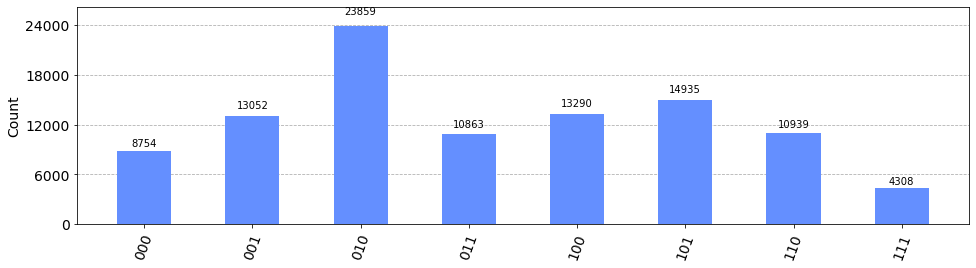

In [478]:
# 3 qubit
gamma=5
beta=3
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(g5.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 5 ,Gamma Post-Otimization: 4.6340221502519015 ,Beta Pre-Otimization: 3 ,Beta Post-Optimization: 2.716213572245972


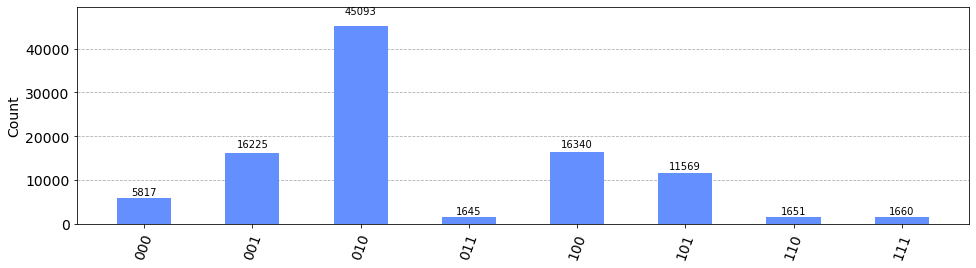

In [479]:
gamma=5
beta=3
theta = [gamma, beta]
expectation = get_expectation(g5, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g5.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["rx"][3].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(16,4))

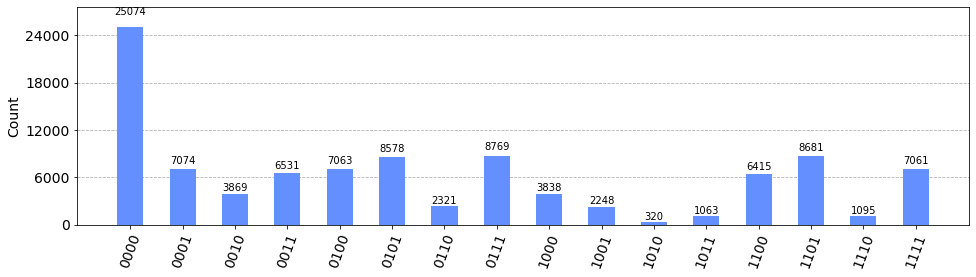

In [480]:
# 4 qubit
gamma=1
beta=1
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(g3.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 1 ,Gamma Post-Otimization: 1.0906608205870794 ,Beta Pre-Otimization: 1 ,Beta Post-Optimization: 1.9753650589660776


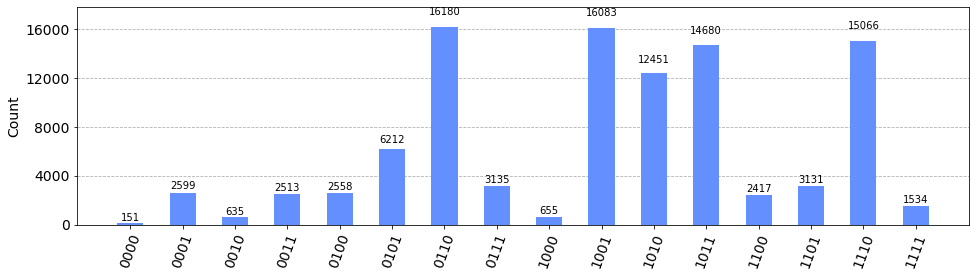

In [481]:
gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation(g3, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g3.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["rx"][4].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

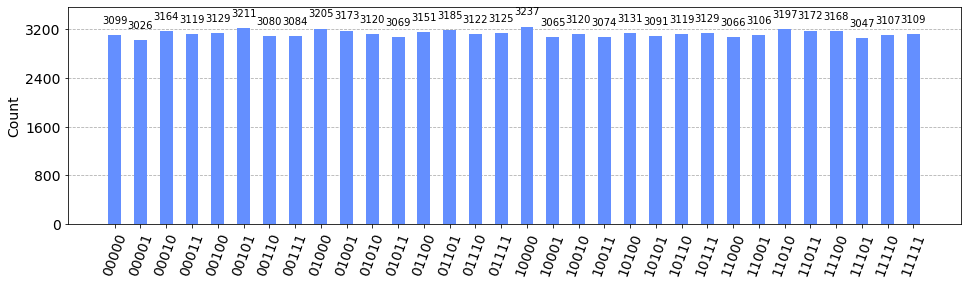

In [482]:
# 5 qubit
gamma=0
beta=0
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(connections,gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 0 ,Gamma Post-Otimization: 1.0583814357722598 ,Beta Pre-Otimization: 0 ,Beta Post-Optimization: 0.3592585105942273


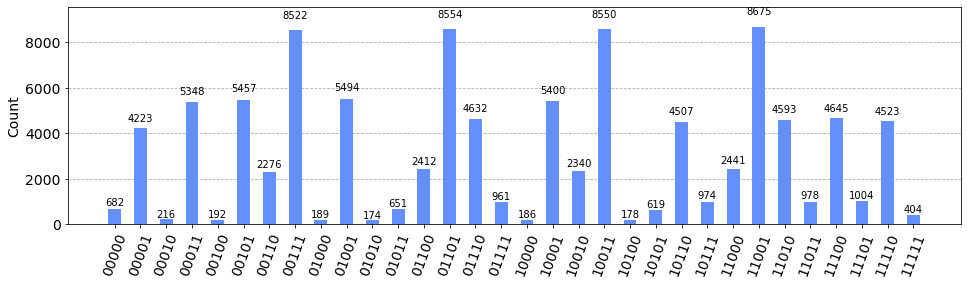

In [483]:
gamma=0
beta=0
theta = [gamma, beta]
expectation = get_expectation(g, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(connections,res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["rx"][5].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

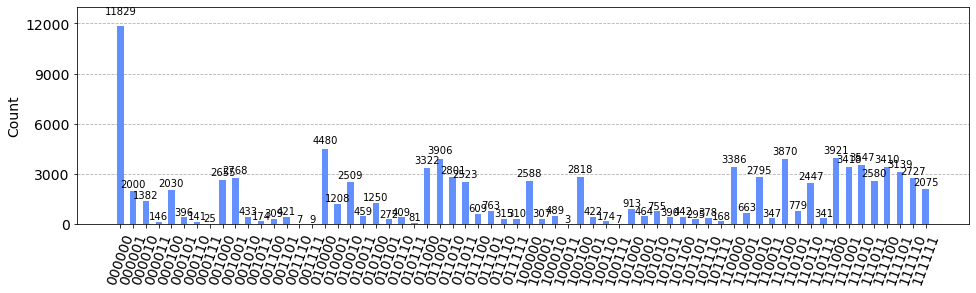

In [484]:
# 6 qubit
gamma=1
beta=1
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(g4.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 1 ,Gamma Post-Otimization: 1.02211047991451 ,Beta Pre-Otimization: 1 ,Beta Post-Optimization: 1.9413356753402127


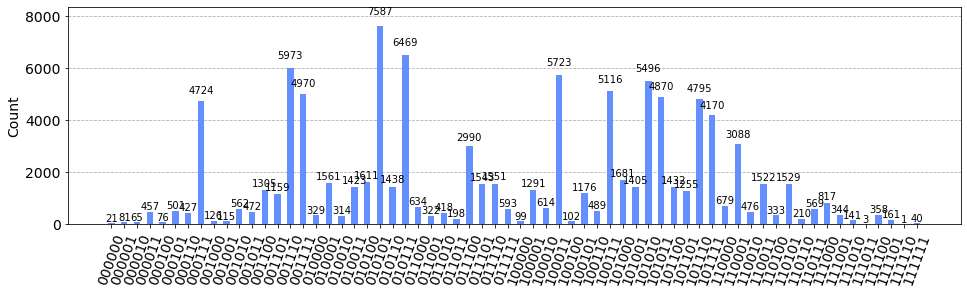

In [485]:
gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation(g4, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g4.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["rx"][6].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(16,4))

# Hadamard Mixer

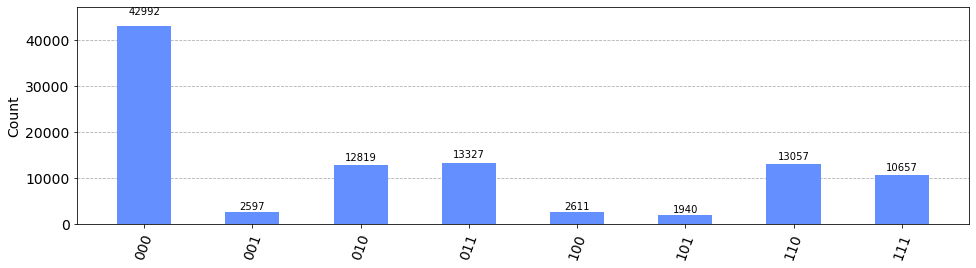

In [486]:
# 3 qubit
gamma=5
beta=3
theta = [gamma, beta]

qc=QAOA_Vertex_Cover_had(g5.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 5 ,Gamma Post-Otimization: 5.419886859921786 ,Beta Pre-Otimization: 3 ,Beta Post-Optimization: 3.890731856026517


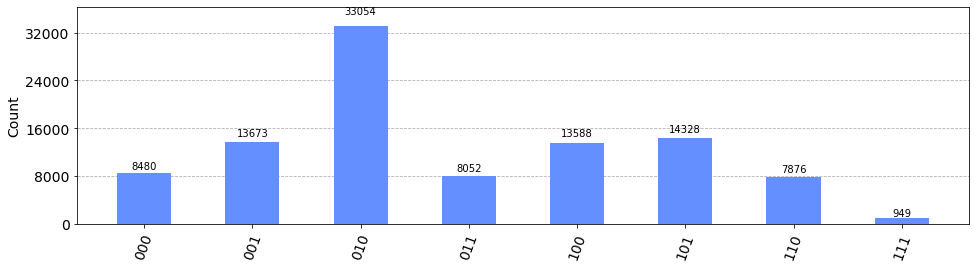

In [487]:
# 3 qubits
gamma=5
beta=3
theta = [gamma, beta]
expectation = get_expectation_had(g5, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_had(g5.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["had"][3].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(16,4))

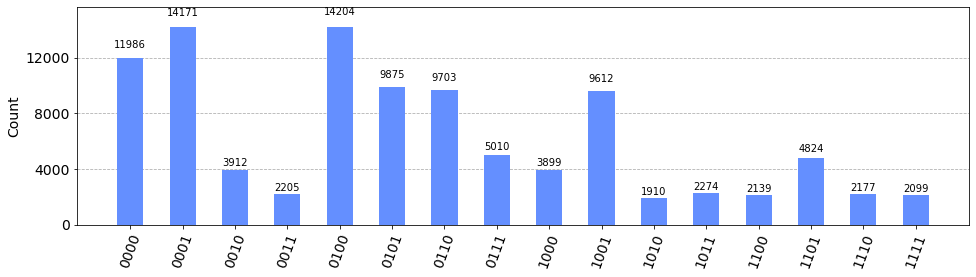

In [488]:
# 4 qubit
gamma=1
beta=1
theta = [gamma, beta]

qc=QAOA_Vertex_Cover_had(g3.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 1 ,Gamma Post-Otimization: 1.7632958001244903 ,Beta Pre-Otimization: 1 ,Beta Post-Optimization: 0.6211239225282842


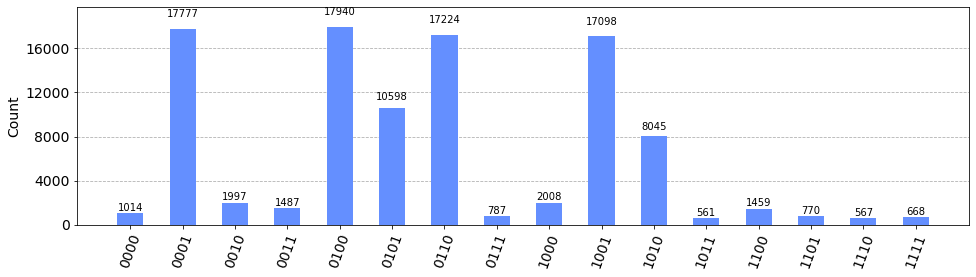

In [489]:
# 4 qubit
gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation_had(g3, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_had(g3.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["had"][4].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

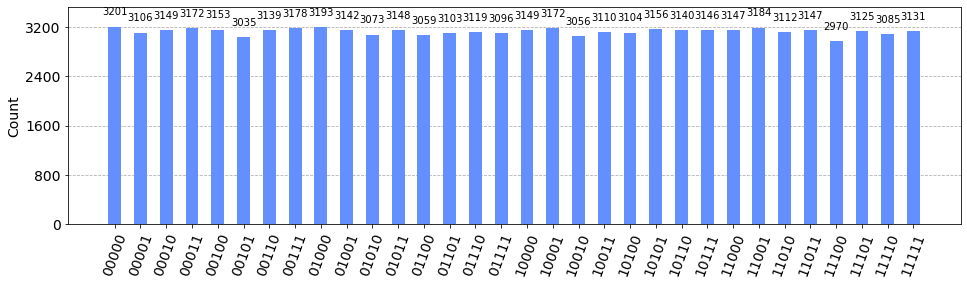

In [490]:
# 5 qubit
gamma=0
beta=0
theta = [gamma, beta]

qc=QAOA_Vertex_Cover_had(connections,gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 5 ,Gamma Post-Otimization: 4.925461923281768 ,Beta Pre-Otimization: 2 ,Beta Post-Optimization: 1.882303509553356


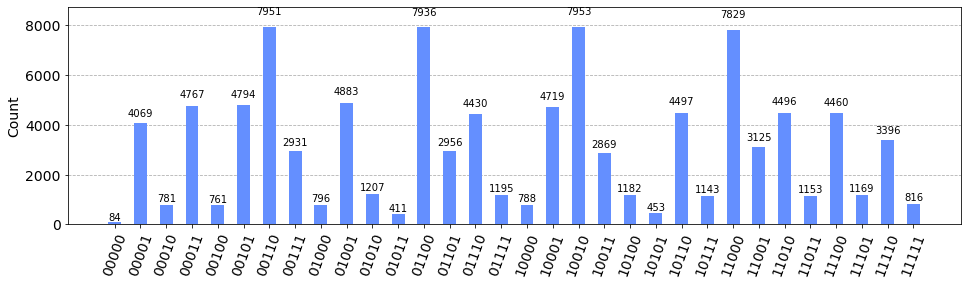

In [491]:
# 5 qubits
gamma=5
beta=2
theta = [gamma, beta]
expectation = get_expectation_had(g, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_had(connections,res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["had"][5].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

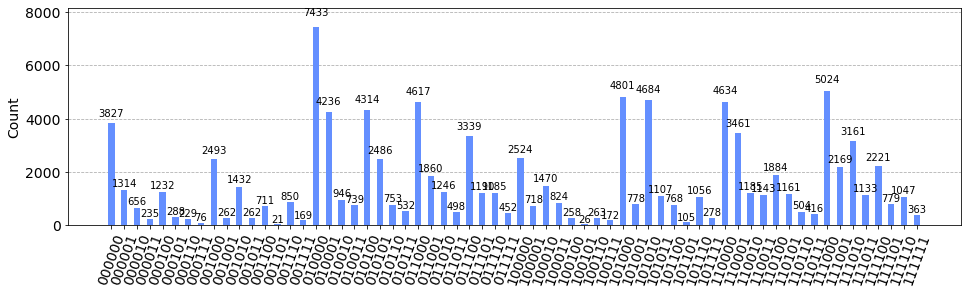

In [492]:
# 6 qubit
gamma=1
beta=1
theta = [gamma, beta]

qc=QAOA_Vertex_Cover_had(g4.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 1 ,Gamma Post-Otimization: 1.511696824132264 ,Beta Pre-Otimization: 1 ,Beta Post-Optimization: 0.6787822370804868


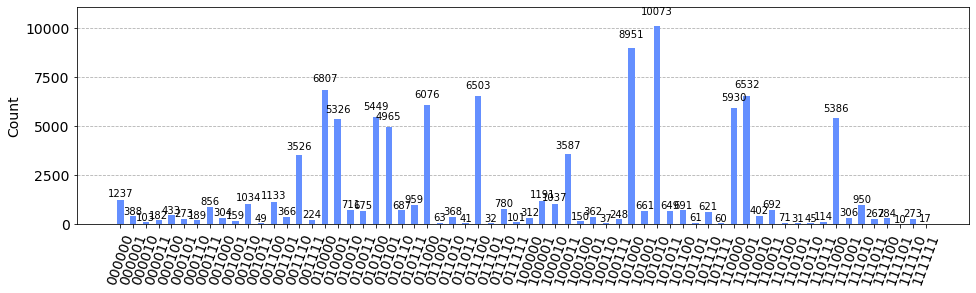

In [493]:
# 6 qubit
gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation_had(g4, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_had(g4.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["had"][6].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(16,4))

In [494]:
print(times["rx"])
print(times["had"])

{3: [0.2609682083129883, 0.2449493408203125], 4: [0.7260339260101318, 0.727999210357666], 5: [0.26903700828552246, 0.3699991703033447], 6: [0.5809681415557861, 0.46002721786499023]}
{3: [0.30498337745666504, 0.28200292587280273], 4: [0.5720016956329346, 0.631019115447998], 5: [0.2619967460632324, 0.2709681987762451], 6: [0.3000016212463379, 0.36896705627441406]}


# Testing on IBM quantum computer

In [495]:
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor

backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 7 and 
                                        not x.configuration().simulator and x.status().operational==True))
shots = backend.configuration().max_shots

# Rx mixer

In [496]:
# 3 qubit

gamma=5
beta=3
theta = [gamma, beta]
expectation = get_expectation(g5, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g5.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["rx"][3].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(16,4))

IBMQBackendApiError: "Error submitting job: '400 Client Error: Bad Request for url: https://api-qcon.quantum-computing.ibm.com/api/Network/ibm-q/Groups/open/Projects/main/Jobs. Error wrong data received., Error code: 2400.'"

In [ ]:
# 4 qubit

gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation(g3, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g3.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["rx"][4].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

In [ ]:
# 5 qubit

gamma=0
beta=0
theta = [gamma, beta]
expectation = get_expectation(g, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(connections,res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["rx"][5].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

In [ ]:
# 6 qubit

gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation(g4, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g4.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["rx"][6].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(16,4))


# Hadamard Mixer

In [ ]:
# 3 qubit

gamma=5
beta=3
theta = [gamma, beta]
expectation = get_expectation_had(g5, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_had(g5.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["had"][3].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(16,4))

In [ ]:
# 4 qubit

gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation_had(g3, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_had(g3.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["had"][4].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

In [ ]:
# 5 qubit

gamma=0
beta=0
theta = [gamma, beta]
expectation = get_expectation_had(g, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_had(connections,res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["had"][5].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts, figsize=(16,4))

In [ ]:
# 6 qubit

gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation_had(g4, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover_had(g4.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
res = backend.run(circ,shots=100000).result()
times["had"][6].append(res.time_taken)
counts = res.get_counts()
plot_histogram(counts,figsize=(16,4))